<a href="https://colab.research.google.com/github/NiallJeffrey/MomentNetworks/blob/master/MomentNetwork_demo/MomentNetwork_grav_wave_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is a Moment Network example with gravitational wave signals
## Using simulated gravitational wave data to estimate the moments of the marginal posterior for the strain $h_+$ at each time step (these would form a $>100$-dimensional posterior distribution) 
## Here we use a dense neural network as a demo, though a CNN would work well for this data and can be easily used in the Moment Network hierarchy.

In [1]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir
!pip install 'git+https://github.com/NiallJeffrey/MomentNetworks.git'

  Cloning https://github.com/NiallJeffrey/MomentNetworks.git to /tmp/pip-req-build-yb1wq3c2
  Running command git clone -q https://github.com/NiallJeffrey/MomentNetworks.git /tmp/pip-req-build-yb1wq3c2
  Created wheel for momentnetworks: filename=momentnetworks-0.1-cp36-none-any.whl size=4190 sha256=45c94e377e88599cf3be2852a88b2f5f63d822d0d2d310769075508b33d1d7e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-oa5e_t1v/wheels/d5/90/42/833efe39b17eb037678ff241c8946e912987034b18c69e2813
Successfully built momentnetworks


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import signal
from google.colab import files
from pycbc.waveform import get_td_waveform
import pycbc.noise
import pycbc.psd
import random
from momentnetworks import demo
import gc

# Generate simulated waveforms and noisy data

In [3]:
%matplotlib inline

In [4]:
n_training = 5000
n_training_samples = n_training*16
print('Number of training samples = '+str(n_training_samples))

Number of training samples = 80000


In [5]:
mass_1_samples = np.random.uniform(10,30,n_training)
mass_2_samples = np.random.uniform(10,30,n_training)
distance_samples = np.random.uniform(500,1500,n_training)
sim_data, sim_data_noisy = demo.grav_wave_series(n_training,
                                                 mass_1_samples=mass_1_samples,
                                                 mass_2_samples=mass_2_samples,
                                                 distance_samples=distance_samples)
noise_alone = sim_data_noisy - sim_data

0/5000
200/5000
400/5000
600/5000
800/5000
1000/5000
1200/5000
1400/5000
1600/5000
1800/5000
2000/5000
2200/5000
2400/5000
2600/5000
2800/5000
3000/5000
3200/5000
3400/5000
3600/5000
3800/5000
4000/5000
4200/5000
4400/5000
4600/5000
4800/5000


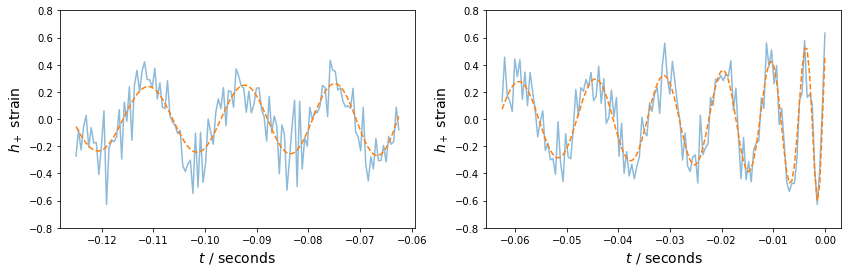

In [6]:
_ =plt.figure(figsize=(14,4))
_ = plt.subplot(1,2,1)
_ = plt.ylabel(r'$h_+$ strain',fontsize=14)
_ =plt.plot(np.linspace(0,1/16.,128)-1/8.,sim_data_noisy[63,:], alpha=0.5), plt.ylim(-.8,0.8)
_ =plt.plot(np.linspace(0,1/16.,128)-1/8.,sim_data[63,:], 'C1--'), plt.xlabel(r'$t\ /$ seconds',fontsize=14)
_ = plt.subplot(1,2,2)
_ = plt.ylabel(r'$h_+$ strain',fontsize=14)
_ =plt.plot(np.linspace(0,1/16.,128)-1/16.,sim_data_noisy[63+int(n_training*8),:], alpha=0.5), plt.ylim(-0.8,0.8)
_ =plt.plot(np.linspace(0,1/16.,128)-1/16.,sim_data[63+int(n_training*8),:], 'C1--'), plt.xlabel(r'$t\ /$ seconds',fontsize=14)


In [20]:
# shuffling is important, otherwise the mergers are all in the second half of the array
shuffled_indices = np.arange(sim_data_noisy.shape[0])
np.random.shuffle(shuffled_indices)
sim_data_noisy= sim_data_noisy[shuffled_indices]
sim_data= sim_data[shuffled_indices]

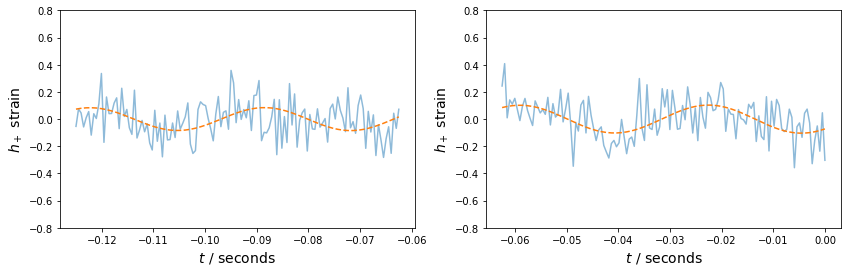

In [31]:
_ =plt.figure(figsize=(14,4))
_ = plt.subplot(1,2,1)
_ = plt.ylabel(r'$h_+$ strain',fontsize=14)
_ =plt.plot(np.linspace(0,1/16.,128)-1/8.,sim_data_noisy[63,:], alpha=0.5), plt.ylim(-.8,0.8)
_ =plt.plot(np.linspace(0,1/16.,128)-1/8.,sim_data[63,:], 'C1--'), plt.xlabel(r'$t\ /$ seconds',fontsize=14)
_ = plt.subplot(1,2,2)
_ = plt.ylabel(r'$h_+$ strain',fontsize=14)
_ =plt.plot(np.linspace(0,1/16.,128)-1/16.,sim_data_noisy[63+int(n_training*8),:], alpha=0.5), plt.ylim(-0.8,0.8)
_ =plt.plot(np.linspace(0,1/16.,128)-1/16.,sim_data[63+int(n_training*8),:], 'C1--'), plt.xlabel(r'$t\ /$ seconds',fontsize=14)


# Train moment network
## As long as the validation loss is decreasing, the estimate of the moment of the marginal posterior is improving

In [32]:
gc.collect()
validation_index = np.int(n_training * 7)
model_instance = demo.simple_leaky(128,128, learning_rate=1e-4)
regression = model_instance.model()

history = regression.fit(sim_data_noisy[:validation_index]+0.5,
                               sim_data[:validation_index]+0.5,
                               epochs =500,batch_size =512, shuffle=True,
                               validation_data = (sim_data_noisy[validation_index:]+0.5,
                               sim_data[validation_index:]+0.5))

128
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 128)         

In [35]:
predicted_mean = regression.predict(np.atleast_2d(sim_data_noisy[:]+0.5))
training_var_unknown_mean = (sim_data[:]+0.5-predicted_mean)**2.
training_var_unknown_mean.shape

(80000, 128)

In [39]:
model_instance = demo.simpler_leaky(128,128, learning_rate=1e-3)
regression_var_unknown_mean = model_instance.model()
history = regression_var_unknown_mean.fit(sim_data_noisy[:validation_index]+0.5,
                                          training_var_unknown_mean[:validation_index]*1e3,
                                          epochs =100,batch_size =512, shuffle=True,
                                          validation_data = (sim_data_noisy[validation_index:]+0.5,
                                                             training_var_unknown_mean[validation_index:]*1e3))

128
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               32896     
Total params: 82,432
Trainable params: 82,432
Non-trainable params: 0
_____________________________________________

40057


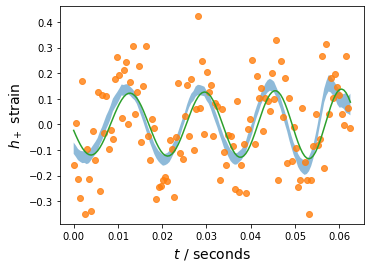

40058


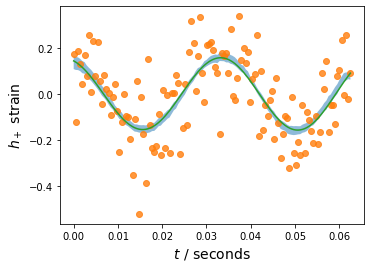

40059


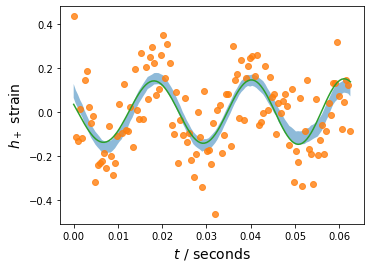

40060


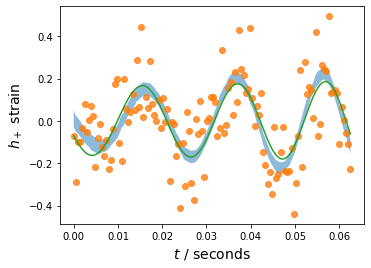

40061


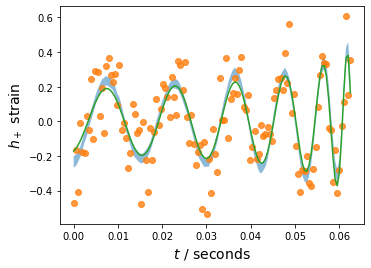

40062


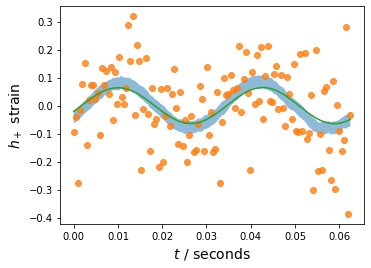

In [40]:
for i_index in np.arange(57+int(n_training*8),63+int(n_training*8)):
  print(i_index)
  predicted_var_obs = (regression_var_unknown_mean.predict(np.atleast_2d(sim_data_noisy[i_index]+0.5))[0])*1e-3
  predicted_mean_obs = (regression.predict(np.atleast_2d(sim_data_noisy[i_index,]+0.5))[0])
  plt.figure(figsize=(12,4))
  _ = plt.subplot(1,2,1)
  _ = plt.ylabel(r'$h_+$ strain',fontsize=14)
  plt.fill_between(np.linspace(0,1./16,128),
                  predicted_mean_obs-0.5- np.sqrt(predicted_var_obs),
                  predicted_mean_obs + np.sqrt(predicted_var_obs)-0.5, alpha=0.5)
  plt.scatter(np.linspace(0,1./16,128),sim_data_noisy[i_index,], alpha=0.8)
  plt.plot(np.linspace(0,1./16,128),sim_data[i_index,], c='C2')
  plt.xlabel(r'$t\ /$ seconds',fontsize=14), plt.show()